In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import google.generativeai as genai

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
import lightgbm as lgb
from econml.solutions.causal_analysis import CausalAnalysis

from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

2025-11-21 09:34:35,341	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### STEP 1:

We assume a company operating in the fintech and e-commerce domains, with access to transactional and behavioral data from both areas.
The target metric for this example is loan conversion — whether a user applies for and receives a loan.

In [2]:
df = pd.read_csv("dataset.csv", index_col=0)

### STEP 2: 

We already have a dataset with the following features:

- avg_check_ecom_last30d - average order amount in e-commerce during the 30 days prior to the reference date (2025-04-01).

- bnpl_3_month_orders_share_last30d - share of e-commerce orders paid via BNPL in the last 30 days before the reference date.

- ecom_active_days_last30d - number of days on which the user performed an active action in e-commerce (placing an order or another defined active event) during the 30 days prior to the reference date (2025-04-01).

- fintech_trx_days_last30d - number of days on which the user performed an active action in fintech (a transaction or another defined active event) during the 30 days prior to the reference date (2025-04-01).

- transaction_count_last30d - total number of fintech transactions made by the user in the last 30 days prior to the reference date (2025-04-01).

- avg_positions_per_order - average number of unique items per e-commerce order in the last 30 days prior to the reference date (2025-04-01).

- age - customer age.

And the target:

- loan_conversion_next30d - indicates whether the user converted into a loan product within the 30 days following the reference date.

Note: In this example, we do not focus on data cleaning or preprocessing.

In [3]:
df.head()

,client_id,loan_conversion_next30d,avg_check_ecom_last30d,bnpl_3_month_orders_share_last30d,ecom_active_days_last30d,fintech_trx_days_last30d,transaction_count_last30d,avg_positions_per_order,ages
0,1,0,112.41,0.10,5.83,5.18,22.11,2,40
1,2,1,112.42,0.09,6.36,2.31,20.21,4,34
2,3,0,143.98,0.19,3.78,7.18,12.47,4,41
3,4,1,154.56,0.24,0.00,3.25,14.00,4,50
4,5,0,110.55,0.25,7.82,0.65,14.17,3,33


In [4]:
df = df.drop(["client_id"], axis=1)

Let’s create an example of feature engineering based on the idea that we want to include only such features that can be influenced through product changes or marketing actions.

One example of this type of actionable feature is the ratio between a user’s e-commerce activity and fintech activity:

In [5]:
EPS = 1e-6

df['ecom_preferred_activity_coef'] = ( df["ecom_active_days_last30d"] / (df["fintech_trx_days_last30d"] + EPS) )

EPS here — a small constant (e.g., 1e-6) to avoid division by zero

This ratio helps capture the user’s relative engagement preference between e-commerce and fintech services.
Since we can influence both sides of this ratio (via marketing campaigns or product changes), it represents a feature relevant for causal analysis.

### STEP 3:

Now we can move to training the models.
The workflow will follow the structure used in the official EconML example:
https://github.com/py-why/EconML/blob/main/notebooks/Solutions/Causal%20Interpretation%20for%20Employee%20Attrition%20Dataset.ipynb

This step includes two sub-steps:

**4.1. Train a predictive model to identify the most important features**

In this part, we use a standard supervised ML model (e.g., LightGBM, CatBoost, or RandomForest) to estimate feature importance with respect to the target loan_conversion_next30d. 
This helps us select a subset of features that are not only predictive but also meaningful for further causal interpretation.

The goal of this sub-step:
- reduce dimensionality,
- avoid redundant features that harm causal models (e.g., highly correlated pairs),
- keep only actionable predictors that could plausibly drive the outcome.

**4.2. Train a causal model to estimate causal relationships between the selected features and the target**

After selecting the most relevant features, we apply a causal inference method (e.g., EconML’s CausalAnalysis) to estimate potential causal effects of each feature on the target metric.

This step helps us:
- understand which features have meaningful causal impact on loan conversion,
- distinguish correlation from potential causality,
- identify levers that product and marketing teams can influence.

In [ ]:
# **4.1. Train a predictive model to identify the most important features**

TARGET_COL = "loan_conversion_next30d"

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

param_grid = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [3, 5, 10]}

clf = LGBMClassifier(
    n_estimators=300,
    objective="binary",
    random_state=42,
    n_jobs=-1)

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
search.fit(x_train, y_train)

best_model = search.best_estimator_
#best_params = search.best_params_

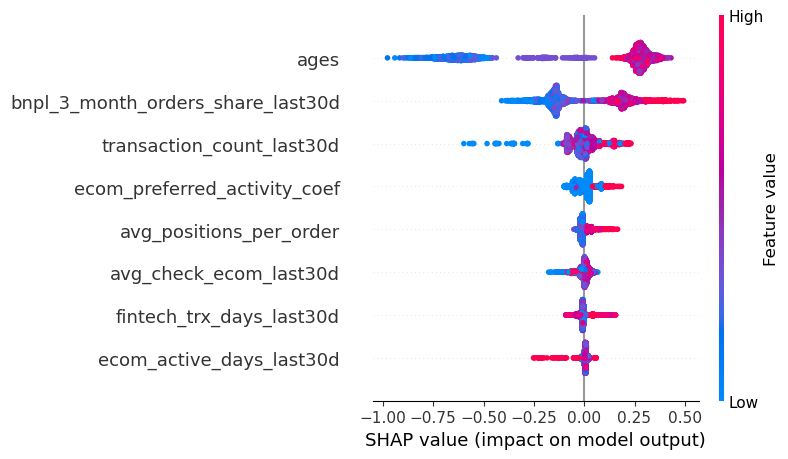

In [7]:
explainer = shap.TreeExplainer(best_model)
shap_exp = explainer(x_train, check_additivity=False)
shap.summary_plot(shap_exp.values, x_train)

In [8]:
vals = np.abs(shap_exp.values).mean(axis=0)

fi_shap = (
    pd.DataFrame({
        "feature": x_train.columns,
        "importance": vals
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True))

In [9]:
top_k = 5
top_features = fi_shap.head(top_k)["feature"].tolist()

We will use the features with the highest importance scores for the next causal analysis step.
For small-dimensional datasets, feature selection is not critical — EconML’s CausalAnalysis works well with 10–15 features.

However:
- if the dataset contains 30+ features,
- and especially if it contains 100,000+ rows,

the memory consumption during the causal estimation stage can become significant, particularly when running the experiment on a local machine.

In such cases, it is recommended to:
- reduce the number of input features (e.g., select top-k based on importance), or
- take a representative sample of the dataset before running causal analysis.

This helps keep computation time and memory usage at manageable levels while preserving the quality of causal estimates.

In [10]:
# **4.2. Train a causal model to estimate causal relationships between the selected features and the target**

MAX_CAUSAL_ROWS = 50000

df_causal = df.copy()
if len(df_causal) > MAX_CAUSAL_ROWS:
    df_causal = df_causal.sample(MAX_CAUSAL_ROWS, random_state=42)

In [ ]:
X_c = df_causal[top_features].copy()
y_c = df_causal[TARGET_COL].astype(int).values

categorical = [c for c in X_c.columns if str(X_c[c].dtype) in ("object", "category")]

ca = CausalAnalysis(
    top_features,
    categorical=categorical,
    heterogeneity_inds=None,
    classification=True,
    nuisance_models="automl",
    heterogeneity_model="forest",
    n_jobs=-1,
    random_state=123,
)
ca.fit(X_c, y_c)

In [12]:
global_summ = ca.global_causal_effect(alpha=0.05) 
global_summ

,point,stderr,zstat,p_value,ci_lower,ci_upper
feature,,,,,,
ages,7.327926e-03,1.055525e-03,6.942446,3.853684e-12,5.259135e-03,9.396717e-03
bnpl_3_month_orders_share_last30d,3.926921e-01,1.194872e-01,3.286479,1.014484e-03,1.585015e-01,6.268826e-01
transaction_count_last30d,1.491420e-03,1.182922e-03,1.260793,2.073833e-01,-8.270643e-04,3.809905e-03
ecom_preferred_activity_coef,5.597895e-09,7.186329e-09,0.778964,4.360007e-01,-8.487051e-09,1.968284e-08
avg_positions_per_order,3.608856e-03,5.446090e-03,0.662651,5.075542e-01,-7.065284e-03,1.428299e-02


In [13]:
def errorbar(res: pd.DataFrame):
    xticks = res.index.get_level_values(0) if isinstance(res.index, pd.MultiIndex) else res.index
    lowererr = res["point"] - res["ci_lower"]
    uppererr = res["ci_upper"] - res["point"]
    xtick_labels = [
        (f"{t}***" if p < 1e-6 else (f"{t}**" if p < 1e-3 else (f"{t}*" if p < 1e-2 else f"{t}")))
        for t, p in zip(xticks, res["p_value"])
    ]
    plt.figure(figsize=(15, 5))
    plt.errorbar(
        np.arange(len(xtick_labels)),
        res["point"].values,
        yerr=[lowererr.values, uppererr.values],
        fmt="o", capsize=5, capthick=1, barsabove=True,
    )
    plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=45, ha="right")
    plt.title("Direct Causal Effect of Each Feature (95% CI)")
    plt.axhline(0, color="r", linestyle="--", alpha=0.5)
    plt.ylabel("Average Treatment Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


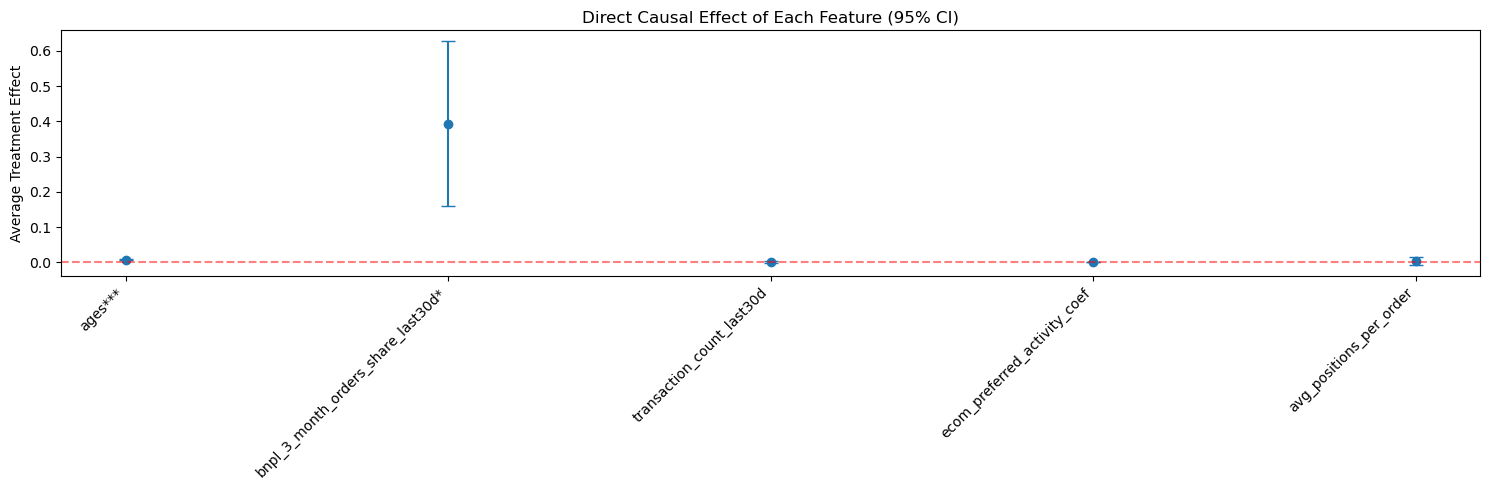

In [14]:
errorbar(global_summ)

### Step 4 (Optional): Additional Validation Techniques

As discussed during the conference, Step 4 is optional.
In this tutorial we skip it, but you may want to apply additional causal validation methods for variables that show non-significant causal effects according to the CausalAnalysis() model.

These techniques help verify whether the absence of detected causality is real or simply a limitation of model assumptions.

Possible validation approaches include:
- Difference-in-Differences (DiD) — [https://causalpy.readthedocs.io/en/latest/notebooks/did_pymc_banks.html]
  Useful when there is a clearly defined before/after period and a treated vs. control group.
- Propensity Score Matching (PSM) 
- Causal Impact 

You can incorporate these techniques if you need more rigorous confirmation of causal relationships or want to validate borderline results.

### STEP 5 

Let's create A/B test desing document automatically, using AI tools.

The columns description will be usefull here:
- avg_check_ecom_last30d - average order amount in e-commerce during the 30 days prior to the reference date (2025-04-01).

- bnpl_3_month_orders_share_last30d - share of e-commerce orders paid via BNPL in the last 30 days before the reference date.

- ecom_active_days_last30d - number of days on which the user performed an active action in e-commerce (placing an order or another defined active event) during the 30 days prior to the reference date (2025-04-01).

- fintech_trx_days_last30d - number of days on which the user performed an active action in fintech (a transaction or another defined active event) during the 30 days prior to the reference date (2025-04-01).

- transaction_count_last30d - total number of fintech transactions made by the user in the last 30 days prior to the reference date (2025-04-01).

- avg_positions_per_order - average number of unique items per e-commerce order in the last 30 days prior to the reference date (2025-04-01).

- age - customer age.

In [15]:
# collect the columns names for get it to AI 

column_descriptions = {}
for col in X_c.columns:
    desc = input(f"Whire the column description '{col}': ")
    column_descriptions[col] = desc

In [16]:
prompt = f"""
You are a Senior Product Data Scientist and Experimentation Expert.

Your task:
Generate a complete, high-quality **A/B Test Design Document**, using ONLY the provided data and following strict experimentation best practices.

===========================================================
INPUT DATA (USE FOR ALL JUSTIFICATIONS)
===========================================================

1) **Top Features (LightGBM Feature Importance):**
{fi_shap.to_markdown(index=False)}

2) **Causal Analysis Summary (feature → effect on target):**
{global_summ.to_markdown(index=False)}

3) **Column Descriptions (JSON Metadata):**
{json.dumps(column_descriptions, ensure_ascii=False, indent=2)}

4) **Target metric used in causal analysis:**
{TARGET_COL}

===========================================================
OUTPUT REQUIREMENTS
===========================================================

Write a concise, professional **A/B Test Design Document** (max 1 page).
Target audience: product managers, data analysts, and executives.

THE DOCUMENT MUST CONTAIN THE FOLLOWING SECTIONS (MANDATORY):

### 1. Objective
Define the business objective and why improving the target metric matters.
Use insights from causal analysis and feature importance to justify relevance.
We need to affect on the target metric {TARGET_COL} not directly, but throught changes user's features only with highest detectable causal effect. 

### 2. Hypothesis
Write a clear, falsifiable, directional hypothesis.
It must be directly grounded in:
- feature importance (drivers of the target)
- causal effects (significant causal contributors)

### 3. Experiment Design (Control vs Treatment)
Describe:
- what exactly changes in Treatment
- why this change can influence the target (via features/causal drivers)
- how users are exposed
- expected behavioral mechanism

### 4. Target Audience / Eligibility Rules
Define inclusion/exclusion based on metadata.
Explain *why this specific audience* is appropriate.

### 5. Metrics
Use column descriptions + model outputs to pick:
- **Primary metric** (must be the target or direct proxy)
- **Secondary metrics** (diagnostic or leading indicators)
- **Expected direction** ↑ or ↓
- **Business interpretation**

Metrics must align with causal results.

### 6. Success Criteria
Provide **clear, measurable** criteria.
If numeric threshold unavailable, define directional criteria with rationale.

### 7. Duration & Sample Size
Provide:
- estimation logic (simplified reasoning is enough)
- expected runtime (days or weeks)
- minimal detectable effect assumptions (conceptual, not calculated)

### 8. Guardrails
Add 2–3 guardrails relating to:
- conversion quality
- risk of negative behavioral shifts
- operational constraints  
Explain *why each guardrail matters*.

### 9. Risks & Mitigations
Provide 3–5 realistic risks.
Each risk must have a corresponding mitigation strategy.

===========================================================
STYLE RULES (STRICT)
===========================================================

- Use Markdown formatting.
- Be concise and avoid generic boilerplate.
- Every claim must be grounded in **importance, causal impact, or feature metadata**.
- Do NOT invent variables or metrics not present in the input.
- Write in a real-world, product-focused tone (no academic verbosity).
- The result must be production-ready, as if included in a real A/B test briefing.

Begin now.
"""

In [17]:
# Select the model and input an API key
LLM_MODEL = "models/gemini-2.5-flash"
model = genai.GenerativeModel(LLM_MODEL)

os.environ["GOOGLE_API_KEY"] = "____" # input your API here
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

In [36]:
OUT_MD = "./ab_test_design_example.md"
try:
    response = model.generate_content(prompt)
    text = getattr(response, "text", "") or "No text generated."

    with open(OUT_MD, "w", encoding="utf-8") as f:
        f.write(text)

    print(f"[Gemini] ✅ Markdown saved to {OUT_MD}")

except Exception as e:
    print(f"[Gemini] ❌ Error: {e}")

[Gemini] ✅ Markdown saved to ./ab_test_design_example.md
